# Test Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read raw test data

In [2]:
amazon = pd.read_csv('/Users/working/Documents/ParsonsSchool/Sp19/MachineLearning/DATASET/amazon_data/raw_data_test.csv')

print(amazon.shape)

(91000, 14)


In [3]:
print(amazon.loc[0, "Text"])

strong taste but good! In my opinion it's not exactly a substitute for coffee but tastes really good mixed together.


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      207103        112082  112083  B002Y2QT2K  A22Y5TJPN98DWB   
1      139933        224640  224641  B009D53XKC  A3MDY6Y3Z6D649   
2       76100        399707  399708  B005GIF5WY  A3LCQXQ4SFYBAU   
3      114178        567900  567901  B005K4Q68Q  A2E65ZXD654761   
4      285272        263134  263135  B002WW3BW8  A1XAZ0MR4TRY16   

                  ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0                Eva Juergens                     1                       1   
1  The Man Behind the Curtain                     1                       1   
2                  Johna Jane                     0                       0   
3                   Barbara L                     0                       0   
4                        bfn1                     0                       0   

   Score        Time                          Summary  \
0      3  1339286400                 chicory "coffee"   
1      5

In [5]:
from gensim.parsing.preprocessing import remove_stopwords
# remove stop words in amazon.Text
amazon['Text'] = amazon['Text'].apply(remove_stopwords)
#newText = amazon['Text'].apply(remove_stopwords)
print(amazon.Text)

0        strong taste good! In opinion it's exactly sub...
1        Those searching high low salt change life end ...
2        These treats picky cat's favorite. I've tried ...
3        The price fantastic taste. So convenient messy...
4        Alot chocolate; coffee bean. Not big caf-kick ...
5        Look ingredients: water, wheat, salt, sugar "t...
6        I love LOVE bread mix. I'm people raised eatin...
7        The Country Choice brand domestically produced...
8        tastes good, easy prepare, separate pouches ea...
9        Only recently I discovered satisying, interest...
10       I enjoyed Tazo tea (Earl Grey favorite) restau...
11       I skeptical sister told drug rep suggested bla...
12       I seven grand kids. 2 fell play ground equipme...
13       I guess I got title wrong. If food left say. I...
14       I bought mini buster cube miniature dachshund ...
15       I'll confess knowing little different coffees....
16       I thrilled flavor available amazon. I seen gro.

### Feature extraction on natural language data

In [6]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [7]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(91000, 131072)


In [8]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [9]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [10]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      3         88
1      5       1936
2      5        105
3      5        118
4      3         85
5      1        147
6      5        448
7      5        817
8      5         60
9      5        382
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [11]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 131074)


### Create `X`, scaled matrix of features

In [12]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 131074)


### create `y`, vector of Labels

In [13]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [14]:
# MODEL: ordinary least squares
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X, y)
# joblib.dump(ols, 'ols.pkl') # pickle
ols = joblib.load('ols.pkl') # pickle

ols_performance = BinaryClassificationPerformance(ols.predict(X), y, 'ols')
ols_performance.compute_measures()
print(ols_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 3165, 'TN': 42844, 'FP': 41549, 'FN': 3442, 'Accuracy': 0.5055934065934066, 'Precision': 0.07078319989265107, 'Recall': 0.47903738459209927, 'desc': 'ols'}


In [15]:
# MODEL: SVM, linear
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X, y)
# joblib.dump(svm, 'svm.pkl') # pickle
svm = joblib.load('svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 1723, 'TN': 78454, 'FP': 5939, 'FN': 4884, 'Accuracy': 0.881065934065934, 'Precision': 0.22487601148525188, 'Recall': 0.2607840169517179, 'desc': 'svm'}


In [16]:
# MODEL: logistic regression
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle
lgs = joblib.load('lgs.pkl')

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 1454, 'TN': 81895, 'FP': 2498, 'FN': 5153, 'Accuracy': 0.915923076923077, 'Precision': 0.36791497975708504, 'Recall': 0.22006962312698652, 'desc': 'lgs'}


In [17]:
# MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle
nbs = joblib.load('nbs.pkl')

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 2628, 'TN': 71740, 'FP': 12653, 'FN': 3979, 'Accuracy': 0.8172307692307692, 'Precision': 0.17197827367318894, 'Recall': 0.39775995156652033, 'desc': 'nbs'}


In [18]:
# MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle
prc = joblib.load('prc.pkl')

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 1771, 'TN': 77936, 'FP': 6457, 'FN': 4836, 'Accuracy': 0.8759010989010989, 'Precision': 0.21524064171122995, 'Recall': 0.26804903889813836, 'desc': 'prc'}


In [19]:
# MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle
rdg = joblib.load('rdg.pkl')

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 948, 'TN': 82986, 'FP': 1407, 'FN': 5659, 'Accuracy': 0.9223516483516484, 'Precision': 0.40254777070063696, 'Recall': 0.14348418344180414, 'desc': 'rdg'}


In [20]:
# MODEL: Decision Tree Classifier
# from sklearn import tree
# dtc = tree.DecisionTreeClassifier(max_depth=100)
# dtc.fit(X_matrix, y)
# joblib.dump(dtc, 'dtc.pkl') # pickle
dtc = joblib.load('dtc.pkl')

dtc_performance = BinaryClassificationPerformance(dtc.predict(X_matrix), y, 'dtc')
dtc_performance.compute_measures()
print(dtc_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 1284, 'TN': 83554, 'FP': 839, 'FN': 5323, 'Accuracy': 0.9322857142857143, 'Precision': 0.6048045219029675, 'Recall': 0.1943393370667474, 'desc': 'dtc'}


### ROC plot to compare performance of various models and fits

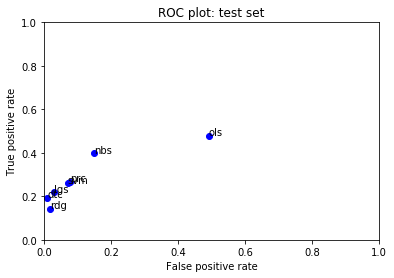

In [21]:
fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance, ols_performance, dtc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ridge Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [22]:
amazon.loc[0, "Text"]

"strong taste good! In opinion it's exactly substitute coffee tastes good mixed together."

In [23]:
amazon.loc[0, "helpful"]

False

In [24]:
ridge_predictions = rdg.predict(X)

In [66]:
ridge_predictions.shape

(91000,)

In [67]:
print(ridge_predictions)

[False False False ... False False False]


In [68]:
# false positives

import random, time

for i in range(0, len(ridge_predictions)):
    if (ridge_predictions[i] == True):
        if (amazon.loc[i, "helpful"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazon.loc[i, "Time"])))
                print(amazon.loc[i, "Score"])
                print(amazon.loc[i, "HelpfulnessDenominator"])
                print(amazon.loc[i, "ProductId"])
                print(amazon.loc[i, "Text"])
                print('* * * * * * * * * ')

6795
2012-01-04 00:00:00
5
2
B001DP4TRQ
"Diet Fountain Mist" for the <a href="http://www.amazon.com/gp/product/B001KYT6CS">Sodastream Fountain Jet Soda Maker Starter Kit</a> is the most preferred "diet" syrup flavor for my family. It does taste a lot like diet Mountain Dew, but I found it takes just a little more than the recommended amount of syrup to get it strong enough.<br /><br />Highly Recommended!<br /><br />CFH
* * * * * * * * * 
25005
2011-02-23 00:00:00
4
0
B002NHYQAS
This chocolate bar arrived today, and I didn't wait very long before trying it! :) What can I say, I can't resist chocolate. And I liked it!<br /><br />It's 54% cacao, so it's not going to be the most intense dark chocolate experience you've ever had. But it's quite tasty, and if you think the darker chocolates are too bitter, this may be exactly what you were looking for.<br /><br />It probably won't make me break up with my usual indulgence, Ghirardelli's squares, but I'd definitely consider a dalliance from t